In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
100% 149M/149M [00:01<00:00, 112MB/s]
100% 149M/149M [00:01<00:00, 128MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
import cv2
import os
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import confusion_matrix, f1_score,classification_report
import seaborn as sns
from tensorflow.keras.layers import Dense, Input, ZeroPadding2D, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.activations import relu, softmax

In [ ]:
train_dataset = image_dataset_from_directory(directory = "/content/Training",
                                       labels = "inferred",
                                       label_mode = "int",
                                       color_mode = "rgb",
                                       batch_size = 32,
                                       image_size = (145, 145),
                                       shuffle = True,
                                       validation_split = 0.2,
                                       subset = "training",
                                       seed =30

                                      )
val_dataset = image_dataset_from_directory(directory = "/content/Training",
                                           labels = "inferred",
                                           label_mode = "int",
                                           color_mode = "rgb",
                                           batch_size = 32,
                                           image_size = (145, 145),
                                           shuffle = True,
                                           validation_split = 0.2,
                                           subset = "validation",
                                           seed =30

                                           )

test_dataset = image_dataset_from_directory(directory = "/content/Testing",
                                            labels = "inferred",
                                            label_mode = "int",
                                            color_mode = "rgb",
                                            image_size = (145, 145),
                                            shuffle = False
                                            )

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [ ]:
print(f"Total classes:= {train_dataset.class_names}")

Total classes:= ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
def count_files_in_subdirs(directory, set_name):

    counts = {}


    for item in os.listdir(directory):

        item_path = os.path.join(directory, item)


        if os.path.isdir(item_path):

            counts[item] = len(os.listdir(item_path))


    df = pd.DataFrame(counts, index=[set_name])
    return df
train_dir = "/content/Training"
test_dir = "/content/Testing"


train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


       pituitary  meningioma  glioma  notumor
train       1457        1339    1321     1595
      pituitary  meningioma  glioma  notumor
test        300         306     300      405


<Axes: >

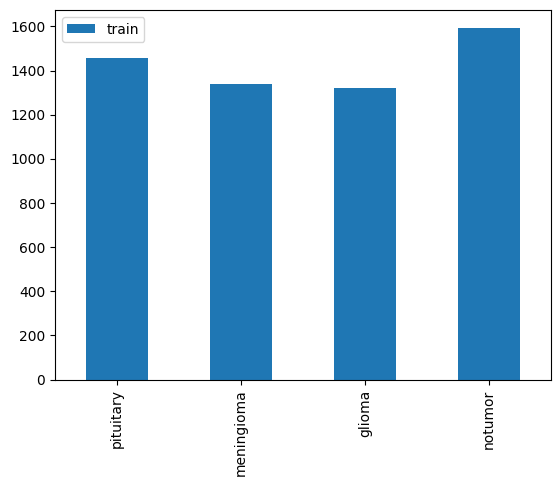

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

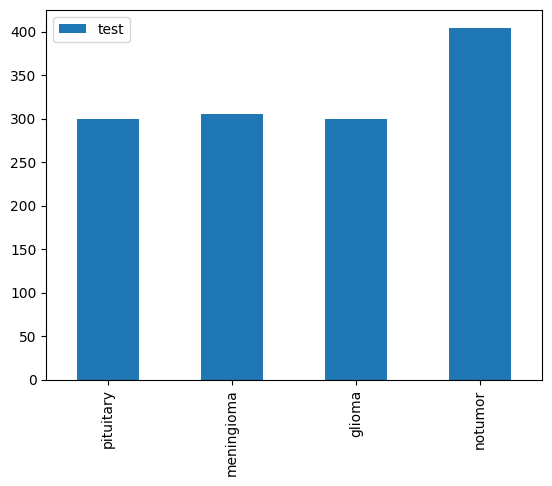

In [ ]:
test_count.transpose().plot(kind='bar')

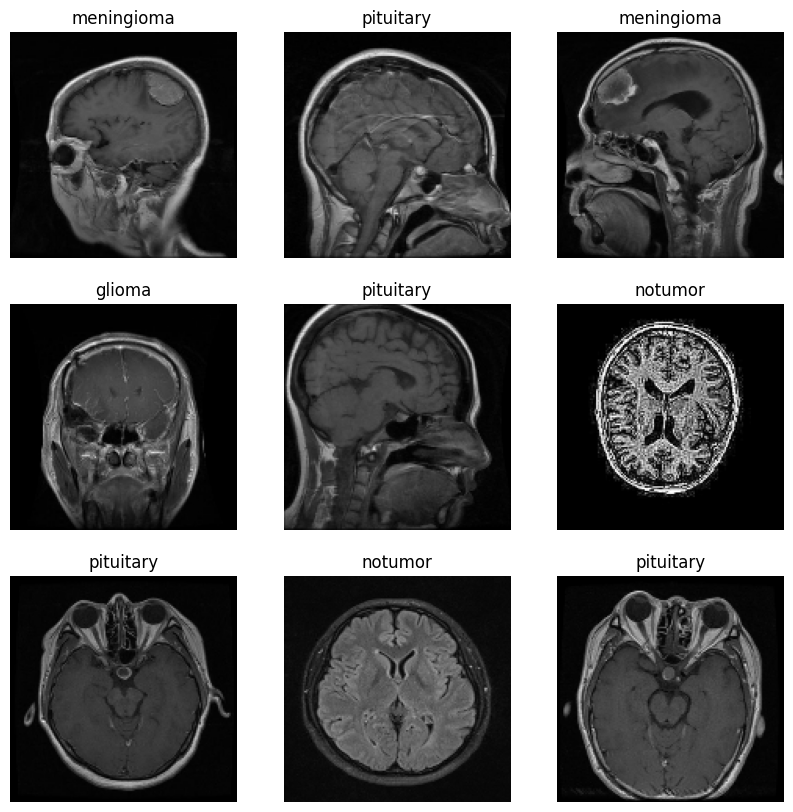

In [ ]:
plt.figure(figsize = (10, 10))

for images, label in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy()/255)
    plt.title(train_dataset.class_names[label[i]])
    plt.axis("off")

In [ ]:
model = Sequential([
    Input((145, 145, 3)),
    tf.keras.layers.Rescaling(scale = 1./255),


    Conv2D(64, 3, strides = (2, 2), activation = "relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),

    Conv2D(128, 3, padding = "same", activation = "relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),

    Dropout(0.4),
    Conv2D(256, 3, padding = "same", activation = "relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),

    Dropout(0.4),
    Conv2D(256, 3, activation = "relu"),
    BatchNormalization(),

    Flatten(),

    Dropout(0.5),
    Dense(256, activation = "relu"),
    BatchNormalization(),
    Dense(128, activation = "relu"),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation = "relu"),
    BatchNormalization(),
    Dense(4, activation = "linear")
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 145, 145, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 72, 72, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 72, 72, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 36, 36, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 36, 36, 128)       5

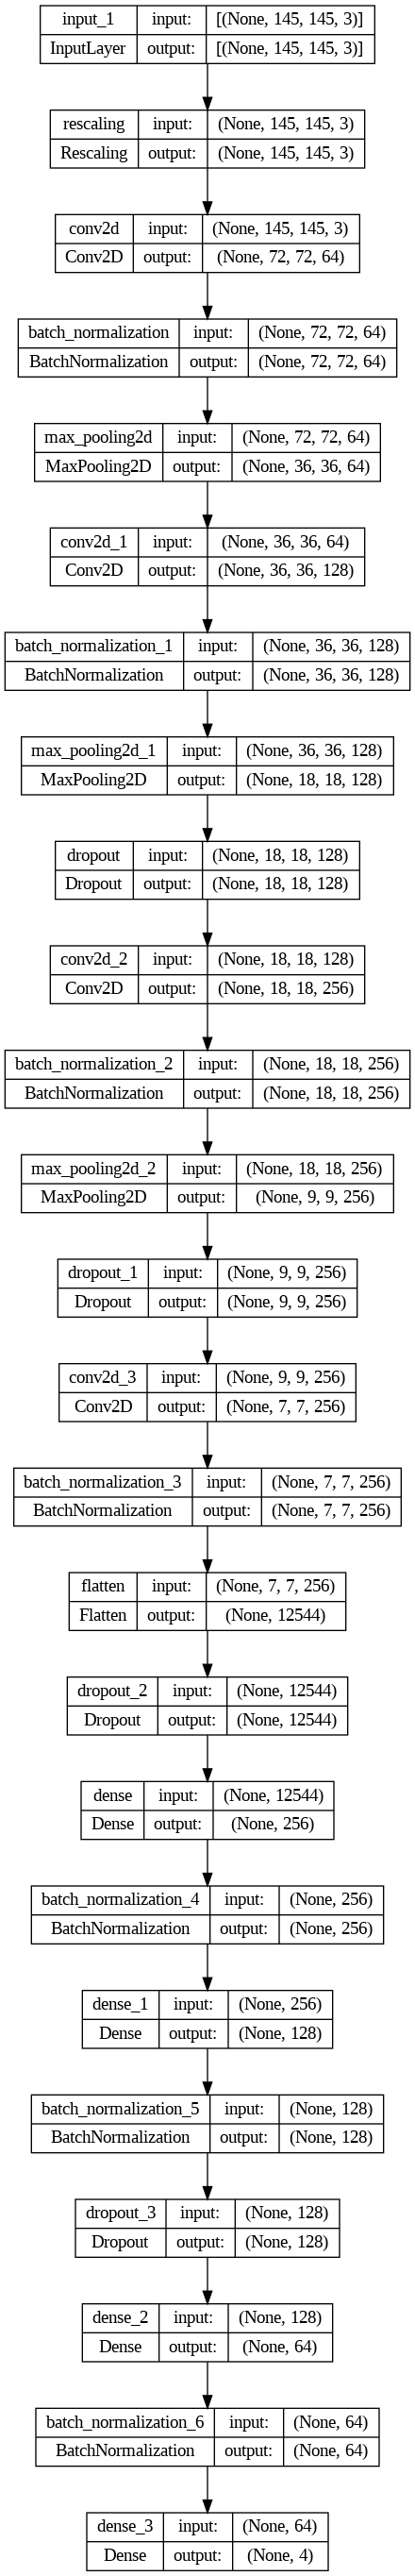

In [ ]:
plot_model(model, show_shapes = True,to_file = "model.png")

In [ ]:
model.compile(optimizer="adam",metrics=['accuracy'],loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True))

In [ ]:
history=model.fit(train_dataset,validation_data=val_dataset,epochs=15)

Epoch 1/15
143/143 [==============================] - 21s 77ms/step - loss: 0.6973 - accuracy: 0.7306 - val_loss: 4.1797 - val_accuracy: 0.3415
Epoch 2/15
143/143 [==============================] - 9s 59ms/step - loss: 0.4580 - accuracy: 0.8254 - val_loss: 2.3654 - val_accuracy: 0.3949
Epoch 3/15
143/143 [==============================] - 7s 48ms/step - loss: 0.3836 - accuracy: 0.8540 - val_loss: 0.8010 - val_accuracy: 0.7452
Epoch 4/15
143/143 [==============================] - 9s 61ms/step - loss: 0.3390 - accuracy: 0.8777 - val_loss: 1.1947 - val_accuracy: 0.6944
Epoch 5/15
143/143 [==============================] - 7s 48ms/step - loss: 0.2958 - accuracy: 0.8871 - val_loss: 0.5298 - val_accuracy: 0.7995
Epoch 6/15
143/143 [==============================] - 9s 60ms/step - loss: 0.2682 - accuracy: 0.8961 - val_loss: 0.3360 - val_accuracy: 0.8949
Epoch 7/15
143/143 [==============================] - 8s 56ms/step - loss: 0.2383 - accuracy: 0.9166 - val_loss: 0.7135 - val_accuracy: 0.775

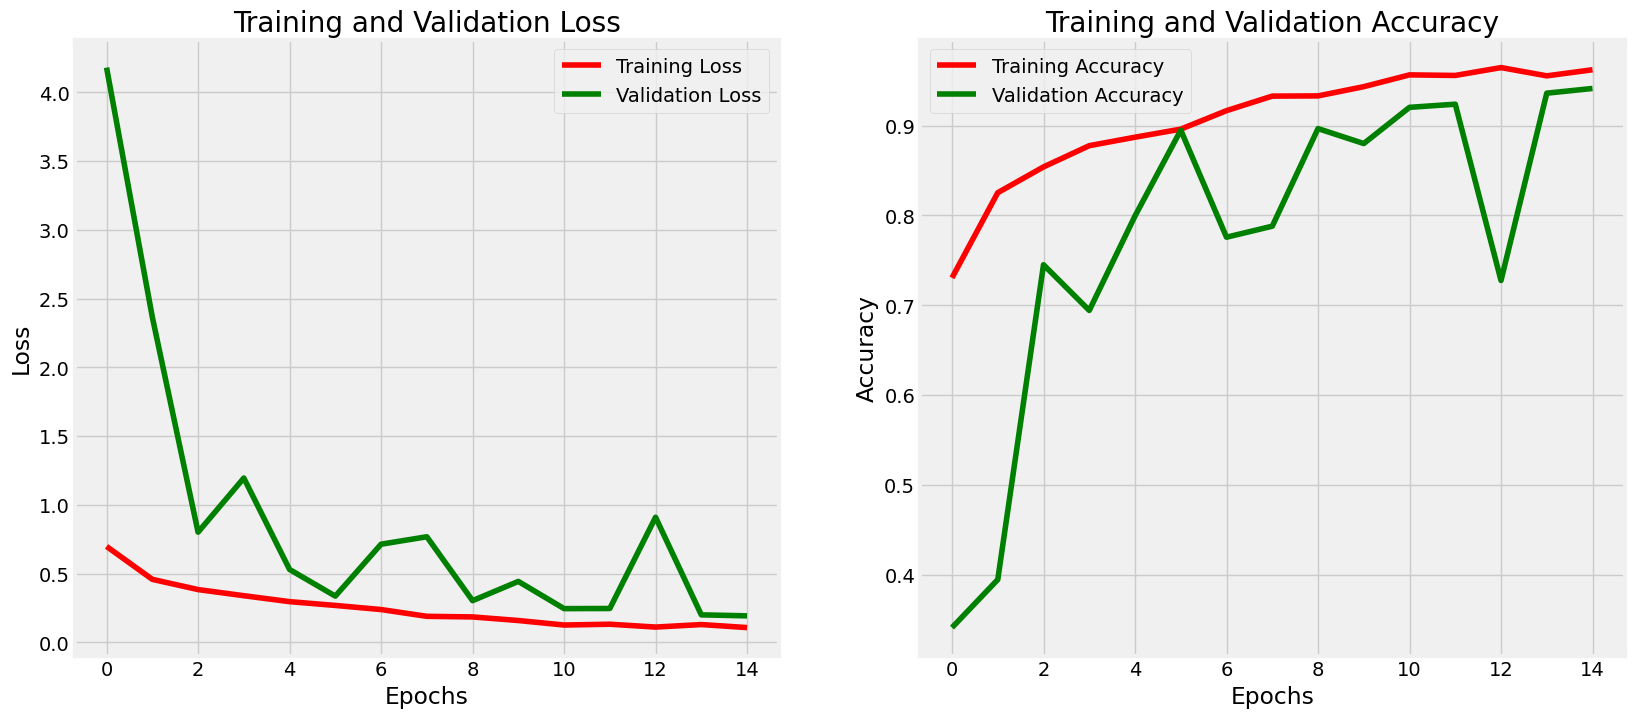

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# index_loss = np.argmin(val_loss)
# val_lowest = val_loss[index_loss]

# index_acc = np.argmax(val_acc)
# val_highest = val_acc[index_acc]

# Epochs = [i+1 for i in range(len(train_acc))]

# loss_label = f'Best epochs = {str(index_loss +1)}'
# acc_label = f'Best epochs = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(train_loss , 'r' , label = 'Training Loss')
plt.plot(val_loss , 'g' , label = 'Validation Loss')
# plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc , 'r' , label = 'Training Accuracy')
plt.plot(val_acc , 'g' , label = 'Validation Accuracy')
# plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [ ]:
train_score = model.evaluate(train_dataset , verbose = 1)
valid_score = model.evaluate(val_dataset , verbose = 1)
test_score = model.evaluate(test_dataset  , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

41/41 [==============================] - 2s 38ms/step - loss: 0.1609 - accuracy: 0.9542
Train Loss:  0.06734418123960495
Train Accuracy:  0.9800875186920166
--------------------
Validation Loss:  0.19252346456050873
Validation Accuracy:  0.9413309693336487
--------------------
Test Loss:  0.1608874499797821
Test Accuracy:  0.9542334079742432


In [ ]:
y_true = [(label) for _, label in test_dataset]
y_true = tf.concat(y_true, axis = 0), [-1, 1]
y_true[0]

<tf.Tensor: shape=(1311,), dtype=int32, numpy=array([0, 0, 0, ..., 3, 3, 3], dtype=int32)>

In [ ]:
preds = model.predict_generator(test_dataset)

y_pred = np.argmax(preds , axis = 1)

<ipython-input-18-784d642b4c28>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_dataset)


In [ ]:
tumor_labels = {'Glioma': 0, 'Meningioma': 1, 'No Tumor': 2, 'Pituitary': 3}
x_label=['Glioma','Meningioma','No Tumor','Pituitary']
y_label=['Glioma','Meningioma','No Tumor','Pituitary']

cm = confusion_matrix(y_true[0], y_pred)

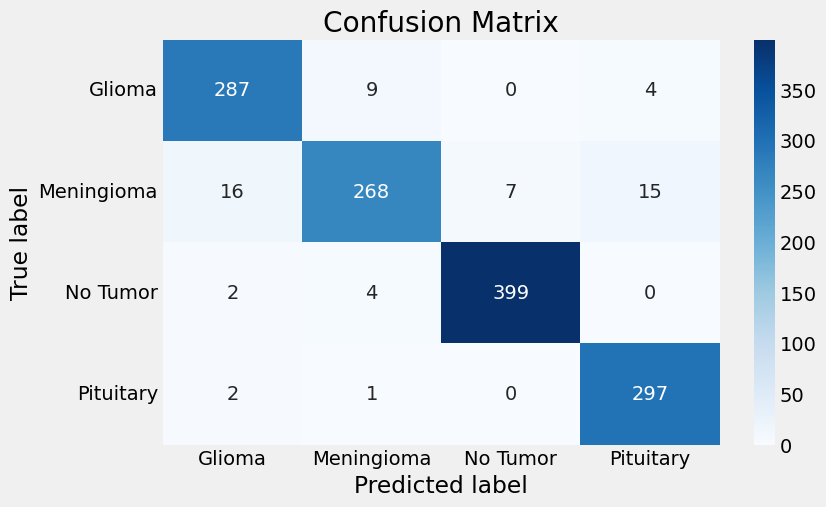

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(cm,annot=True,xticklabels=x_label, yticklabels=y_label,fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
report = classification_report(y_true[0], y_pred,target_names=x_label)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      Glioma       0.93      0.96      0.95       300
  Meningioma       0.95      0.88      0.91       306
    No Tumor       0.98      0.99      0.98       405
   Pituitary       0.94      0.99      0.96       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



1/1 [==============================] - 0s 190ms/step


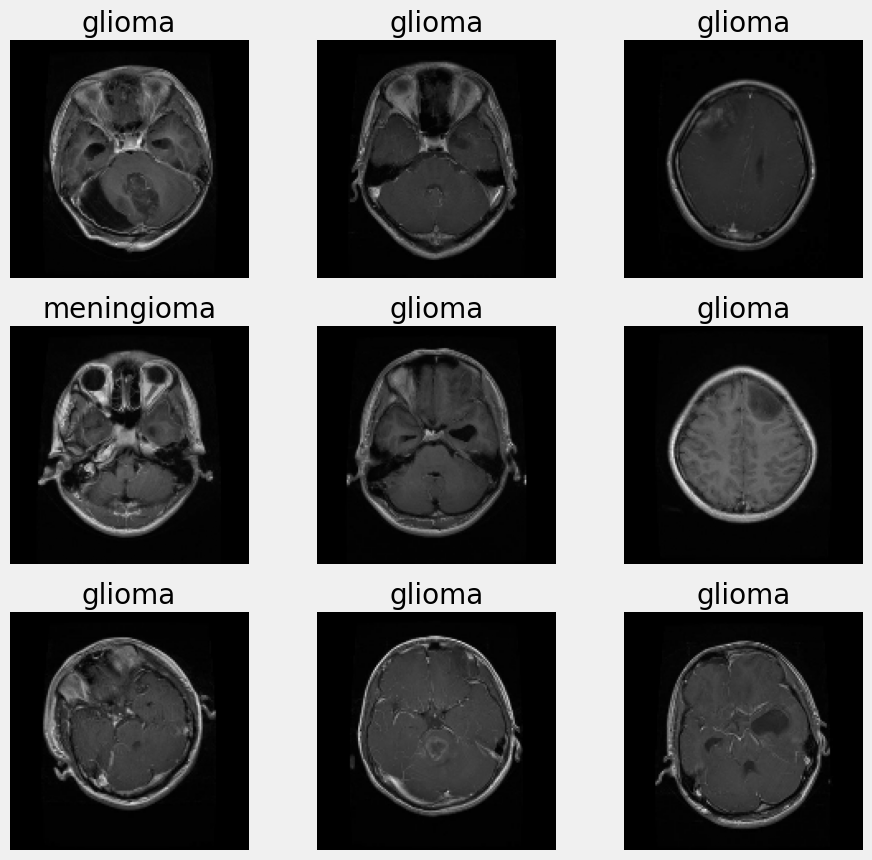

In [ ]:
plt.figure(figsize = (10, 10))

images ,labels = next(iter(test_dataset))
name = np.argmax((model.predict(images)), axis = 1)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy()/255)
    plt.title(test_dataset.class_names[name[i]])
#     print(name)
    plt.axis("off")

In [ ]:
def prediction(img):
  pic=cv2.imread(img)
  pic=cv2.resize(pic,(145,145))
  test=pic.reshape((1,145,145,3))
  predict=model.predict(test)


  if np.argmax(predict)==0:
    print("Patient has Tumor :- Glioma")
  elif np.argmax(predict)==1:
      print("Patient has Tumor :- Meningioma")
  elif np.argmax(predict)==2:
      print("Patient has No Tumor")
  elif np.argmax(predict)==3:
          print("Patient has Tumor :- Pituitary")


# prediction("/content/Testing/pituitary/Te-piTr_0000.jpg")


In [ ]:


tumor_labels = {'Glioma': 0, 'Meningioma': 1, 'No Tumor': 2, 'Pituitary': 3}
index_to_tumor = {v: k for k, v in tumor_labels.items()}
index_to_tumor


{0: 'Glioma', 1: 'Meningioma', 2: 'No Tumor', 3: 'Pituitary'}

In [ ]:
def prepare_image(img_pil):
    """Preprocess the PIL image to fit your model's input requirements."""
    # Convert the PIL image to a numpy array with the target size
    img = img_pil.resize((145, 145))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Convert single image to a batch.
    # img_array /= 255.0  # Rescale pixel values to [0,1], as done during training
    return img_array



# Define the Gradio interface
def predict_emotion(image):
    # Preprocess the image
    processed_image = prepare_image(image)
    # Make prediction using the model
    prediction = model.predict(processed_image)
    # Get the emotion label with the highest probability
    predicted_class = np.argmax(prediction, axis=1)
    predicted_emotion = index_to_tumor.get(predicted_class[0], "Unknown Emotion")
    return predicted_emotion

interface = gr.Interface(
    fn=predict_emotion,  # Your prediction function
    inputs=gr.Image(type="pil"),  # Input for uploading an image, directly compatible with PIL images
    outputs="text",  # Output as text displaying the predicted emotion
    title="Emotion Detection",
    description="Upload an image and see the predicted emotion."
)

# Launch the Gradio interface
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://cee1d626d0762b1655.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
# def predict(image):

#     processed_image = prepare(image)
#     prediction = model.predict(processed_image)
#     predicted_class = np.argmax(prediction, axis=1)
#     predicted_tumor = index_to_tumor.get(predicted_class[0], "Unknown")
#     return predicted_tumor

# # predict("/content/Testing/glioma/Te-glTr_0002.jpg")

In [ ]:
import gradio as gr

In [ ]:
# interface = gr.Interface(
#     fn=predict,  # Your prediction function
#     inputs=gr.Image(type="pil"),  # Input for uploading an image, directly compatible with PIL images
#     outputs="text",  # Output as text displaying the predicted emotion
#     title="Emotion Detection",
#     description="Upload an image and see the predicted emotion."
# )

# # Launch the Gradio interface
# interface.launch()